In [2]:

%load_ext autoreload
%autoreload 2
import common.utils as utils
import common.analysis as analysis
import pandas as pd
import seaborn as sns
import os
import numpy as np
import common.lazy as lazy
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set_theme()

In [3]:
func = "go-factorial"
definition = utils.getBenchmarkDefinition(f"go-factorial-breakpoint")
outputFolder = f"output/{definition['name']}"
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
realBreakpointRun1 = f"{func}-breakpoint-1"
realBreakpointRun2 = f"{func}-breakpoint-2"
mockBreakpointRun1 = f"{func}-breakpoint-mock-1"

In [4]:
def readAllReplicaResults(runName: str):
  runNumbers = ["1", "32"]
  runs = [analysis.withLoadGrouping(lazy.getHttRequestStats(runName, r)) for r in runNumbers]
  return pd.concat(runs)

In [5]:
httpsStatsReal1 = readAllReplicaResults(realBreakpointRun1)

In [6]:
httpsStatsReal2 = readAllReplicaResults(realBreakpointRun2)

In [7]:
httpStatsMock = readAllReplicaResults(mockBreakpointRun1)

/tmp/ipykernel_636293/883433201.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wasserstein = bothReal.groupby(["load_type", "replicas"])[["load_type", "replicas", "source", "value"]].apply(wassersteinDistance).reset_index(name="wasserstein")
/tmp/ipykernel_636293/883433201.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wassersteinRealAndMock = realAndMock.groupby(["load_type", "replicas"])[["load_type", "replicas", "source", "value"]].apply(wassersteinDistance).reset_index(name="wasserstein")


                           wasserstein
load_type replicas source             
minimum   1        mock       0.821894
          32       mock       0.673184
medium    1        mock       0.572039
          32       mock       1.546001
large     1        mock       1.540148
          32       mock       1.251847
maximum   1        mock     121.953581
          32       mock     123.172526


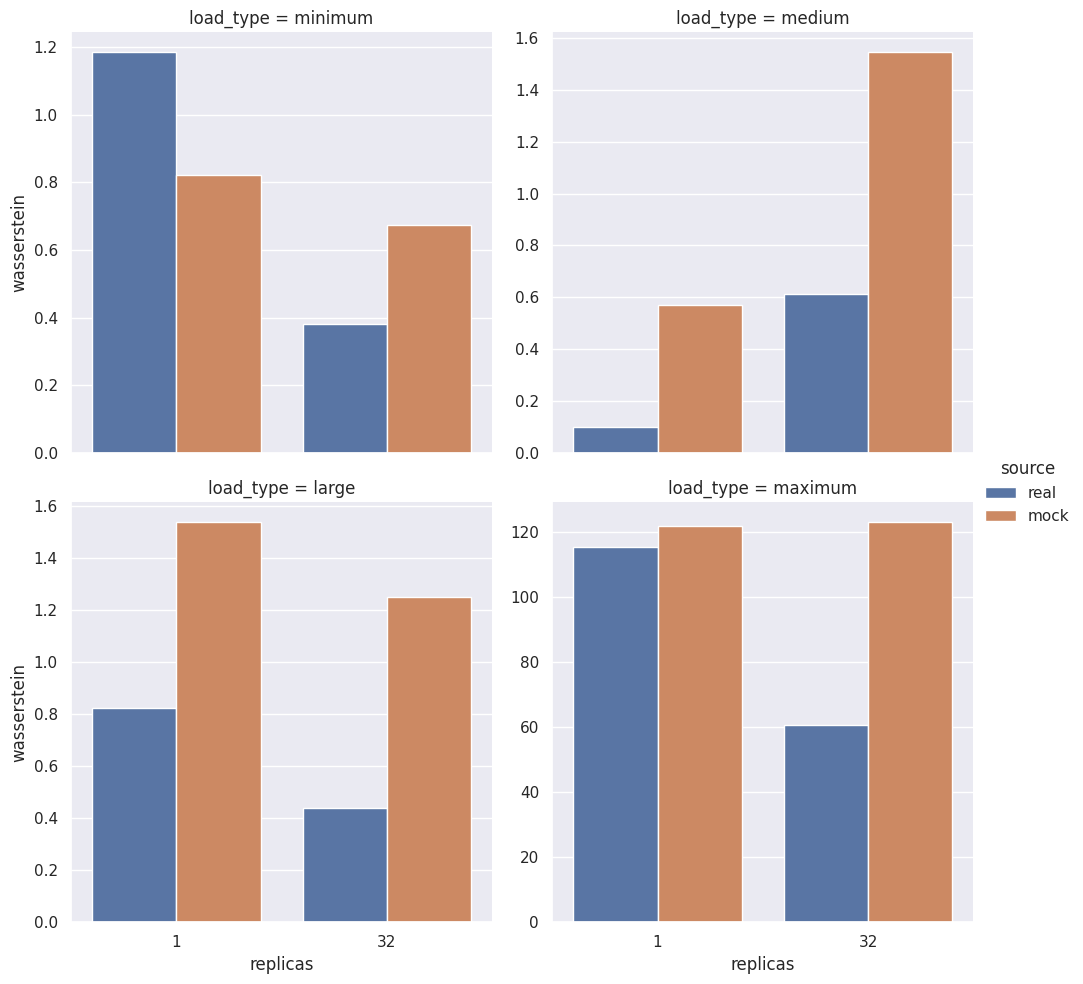

In [9]:
# calculate wasserstein distance for load_type minimum, medium, large and maximum between real1 and real2 and real1 and mock for each number of replicas
def wassersteinDistance(x):
  real = x.query("source == 'real'")
  mock = x.query("source == 'mock'")
  if len(real) == 0 or len(mock) == 0:
    return None
  return stats.wasserstein_distance(real["value"], mock["value"])

httpsStatsReal1["source"] = "real"
httpsStatsReal2["source"] = "mock"
bothReal = pd.concat([httpsStatsReal1, httpsStatsReal2])
wasserstein = bothReal.groupby(["load_type", "replicas"])[["load_type", "replicas", "source", "value"]].apply(wassersteinDistance).reset_index(name="wasserstein")
wasserstein["source"] = "real"
wasserstein.set_index(["load_type", "replicas","source"], inplace=True)

httpStatsMock["source"] = "mock"
realAndMock = pd.concat([httpsStatsReal1, httpStatsMock])
wassersteinRealAndMock = realAndMock.groupby(["load_type", "replicas"])[["load_type", "replicas", "source", "value"]].apply(wassersteinDistance).reset_index(name="wasserstein")
wassersteinRealAndMock["source"] = "mock"
wassersteinRealAndMock.set_index(["load_type", "replicas", "source"], inplace=True)
print(wassersteinRealAndMock)
joined = pd.concat([wasserstein, wassersteinRealAndMock])
joined.reset_index(inplace=True)

sns.catplot(data=joined, x="replicas", y="wasserstein", hue="source", col="load_type", kind="bar", sharey=False, col_wrap=2)